In [1]:
# mount the google drive where the data is stored

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# checking if the file exists

import os
file_path = "/content/drive/MyDrive/IIT Jodhpur/charts/train_val.csv"
print(os.path.exists(file_path))

True


In [3]:
# read the csv file

import pandas as pd

df = pd.read_csv(file_path)
df.head()

,image_index,type
0,0,vbar_categorical
1,1,vbar_categorical
2,2,vbar_categorical
3,3,vbar_categorical
4,4,vbar_categorical


In [4]:
# see the different labels names associated the images

df.type.unique()

array(['vbar_categorical', 'hbar_categorical', 'line', 'pie', 'dot_line'],
      dtype=object)

In [6]:
# fetching the training and validation image name

train_dir = "/content/drive/MyDrive/IIT Jodhpur/charts/train_val"

import os
train_paths = os.listdir(train_dir)
print(len(train_paths))

1000


In [8]:
# using split function, image_index were searched in the dataframe to locate the corrosponding image

import numpy as np
import cv2
def sort_data(dir, data, df):
    images = []
    labels = []
    for i in range(len(data)):
        img = cv2.imread(os.path.join(dir, data[i])) # reading the image
        index = int(data[i].split(".")[0])
        label = df.loc[index, 'type']                # searching the label name associated with the image index
        labels.append(label)
        images.append(img)
    return np.array(images), np.array(labels)

X_train, Y_train = sort_data(train_dir, train_paths, df)

print(X_train.shape)
print(Y_train.shape)

(1000, 128, 128, 3)
(1000,)


In [9]:
# spliting the data into training(80%) and validation(20%)

from sklearn.model_selection import train_test_split
 
x_train, x_validation, y_train, y_validation = train_test_split(
    X_train, 
    Y_train, 
    test_size=200, 
    shuffle=True,
    random_state=42,
    stratify=Y_train
)

print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)

(800, 128, 128, 3)
(800,)
(200, 128, 128, 3)
(200,)


In [10]:
# checking if the samples are distributed among all the categories
print(np.unique(y_train, return_counts=True))
print(np.unique(y_validation, return_counts=True))

(array(['dot_line', 'hbar_categorical', 'line', 'pie', 'vbar_categorical'],
      dtype='<U16'), array([160, 160, 160, 160, 160]))
(array(['dot_line', 'hbar_categorical', 'line', 'pie', 'vbar_categorical'],
      dtype='<U16'), array([40, 40, 40, 40, 40]))


In [11]:
# integer encoding for the labels

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_validation_enc = le.transform(y_validation)

print(np.unique(y_train_enc, return_counts=True))
print(np.unique(y_validation_enc, return_counts=True))

(array([0, 1, 2, 3, 4]), array([160, 160, 160, 160, 160]))
(array([0, 1, 2, 3, 4]), array([40, 40, 40, 40, 40]))


In [12]:
print(y_train[5])
print(np.array(y_train_enc[5]))

vbar_categorical
4


In [33]:
# reading the test data for model predictions

test_dir = "/content/drive/MyDrive/IIT Jodhpur/charts/test"
test_imgs = os.listdir(test_dir)

x_test = []
for img in test_imgs:
    im = cv2.imread(os.path.join(test_dir, img))
    x_test.append(im)
x_test = np.array(x_test)
print(x_test.shape)

(50, 128, 128, 3)


Randomly ploting some of the training data along with labels and integer encoding

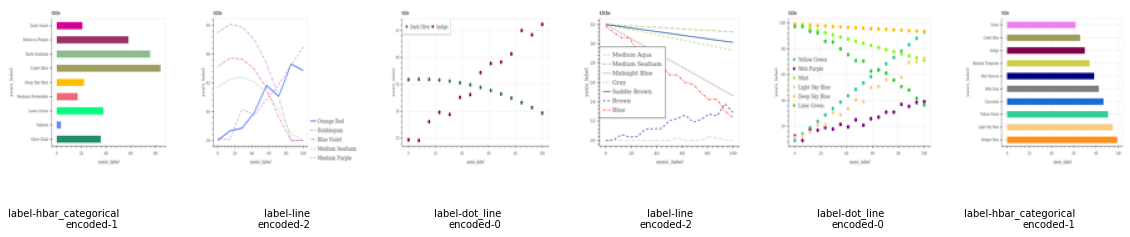

In [16]:
import matplotlib.pyplot as plt
import cv2
n = np.random.randint(0, 800, 6)
plt.figure(figsize=(20, 4))
for i in range(1, len(n)+1): 
    ax = plt.subplot(1, len(n), i)
    img = x_train[n[i-1]]
    plt.imshow(img)
    ax.text(0.7, -0.4, "label-{0}\nencoded-{1}".format(y_train[n[i-1]], y_train_enc[n[i-1]]),
    verticalalignment='bottom', horizontalalignment='right',
    transform=ax.transAxes, fontsize=10)
    plt.axis("off")
plt.show()

In [17]:
print(y_train.shape)
print(y_validation.shape)

(800,)
(200,)


In [18]:
# enum class to help looking at prediction outputs

from enum import Enum
class Number(Enum):
    dot_line = 0
    hbar = 1
    line = 2
    pie = 3
    vbar = 4

Import pre-trained vgg16 and using first 14 for transfer learning

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

vgg16 = tf.keras.applications.VGG16(weights='imagenet',
                                    input_shape=(128, 128, 3),
                                    include_top=False)
vgg16.trainable = False
x = vgg16.layers[14].output
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(5)(x)

model = keras.Model(vgg16.input, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(x_train, y_train_enc, batch_size=16, validation_data=(x_validation, y_validation_enc), epochs=2)

Epoch 1/2
50/50 [==============================] - 11s 63ms/step - loss: 68.1596 - sparse_categorical_accuracy: 0.9212 - val_loss: 1.9496 - val_sparse_categorical_accuracy: 0.9950
Epoch 2/2
50/50 [==============================] - 2s 34ms/step - loss: 0.1835 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000


Ploting the training and validation accuracy and loss

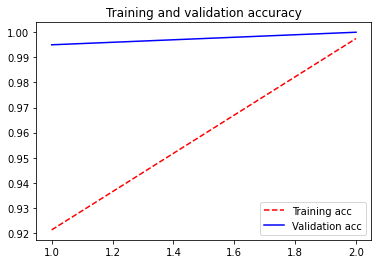

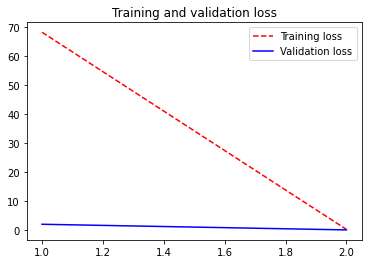

In [28]:
def plot_accuracy_and_loss(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '--r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, '--r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_accuracy_and_loss(history)

In [32]:
# save the model later inference

model.save("/content/drive/MyDrive/IIT Jodhpur/models/tf:vgg16-validationAcc-1.0")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIT Jodhpur/models/tf:vgg16-validationAcc-1.0/assets


Now lets look at some the predictions done by the model on the test set

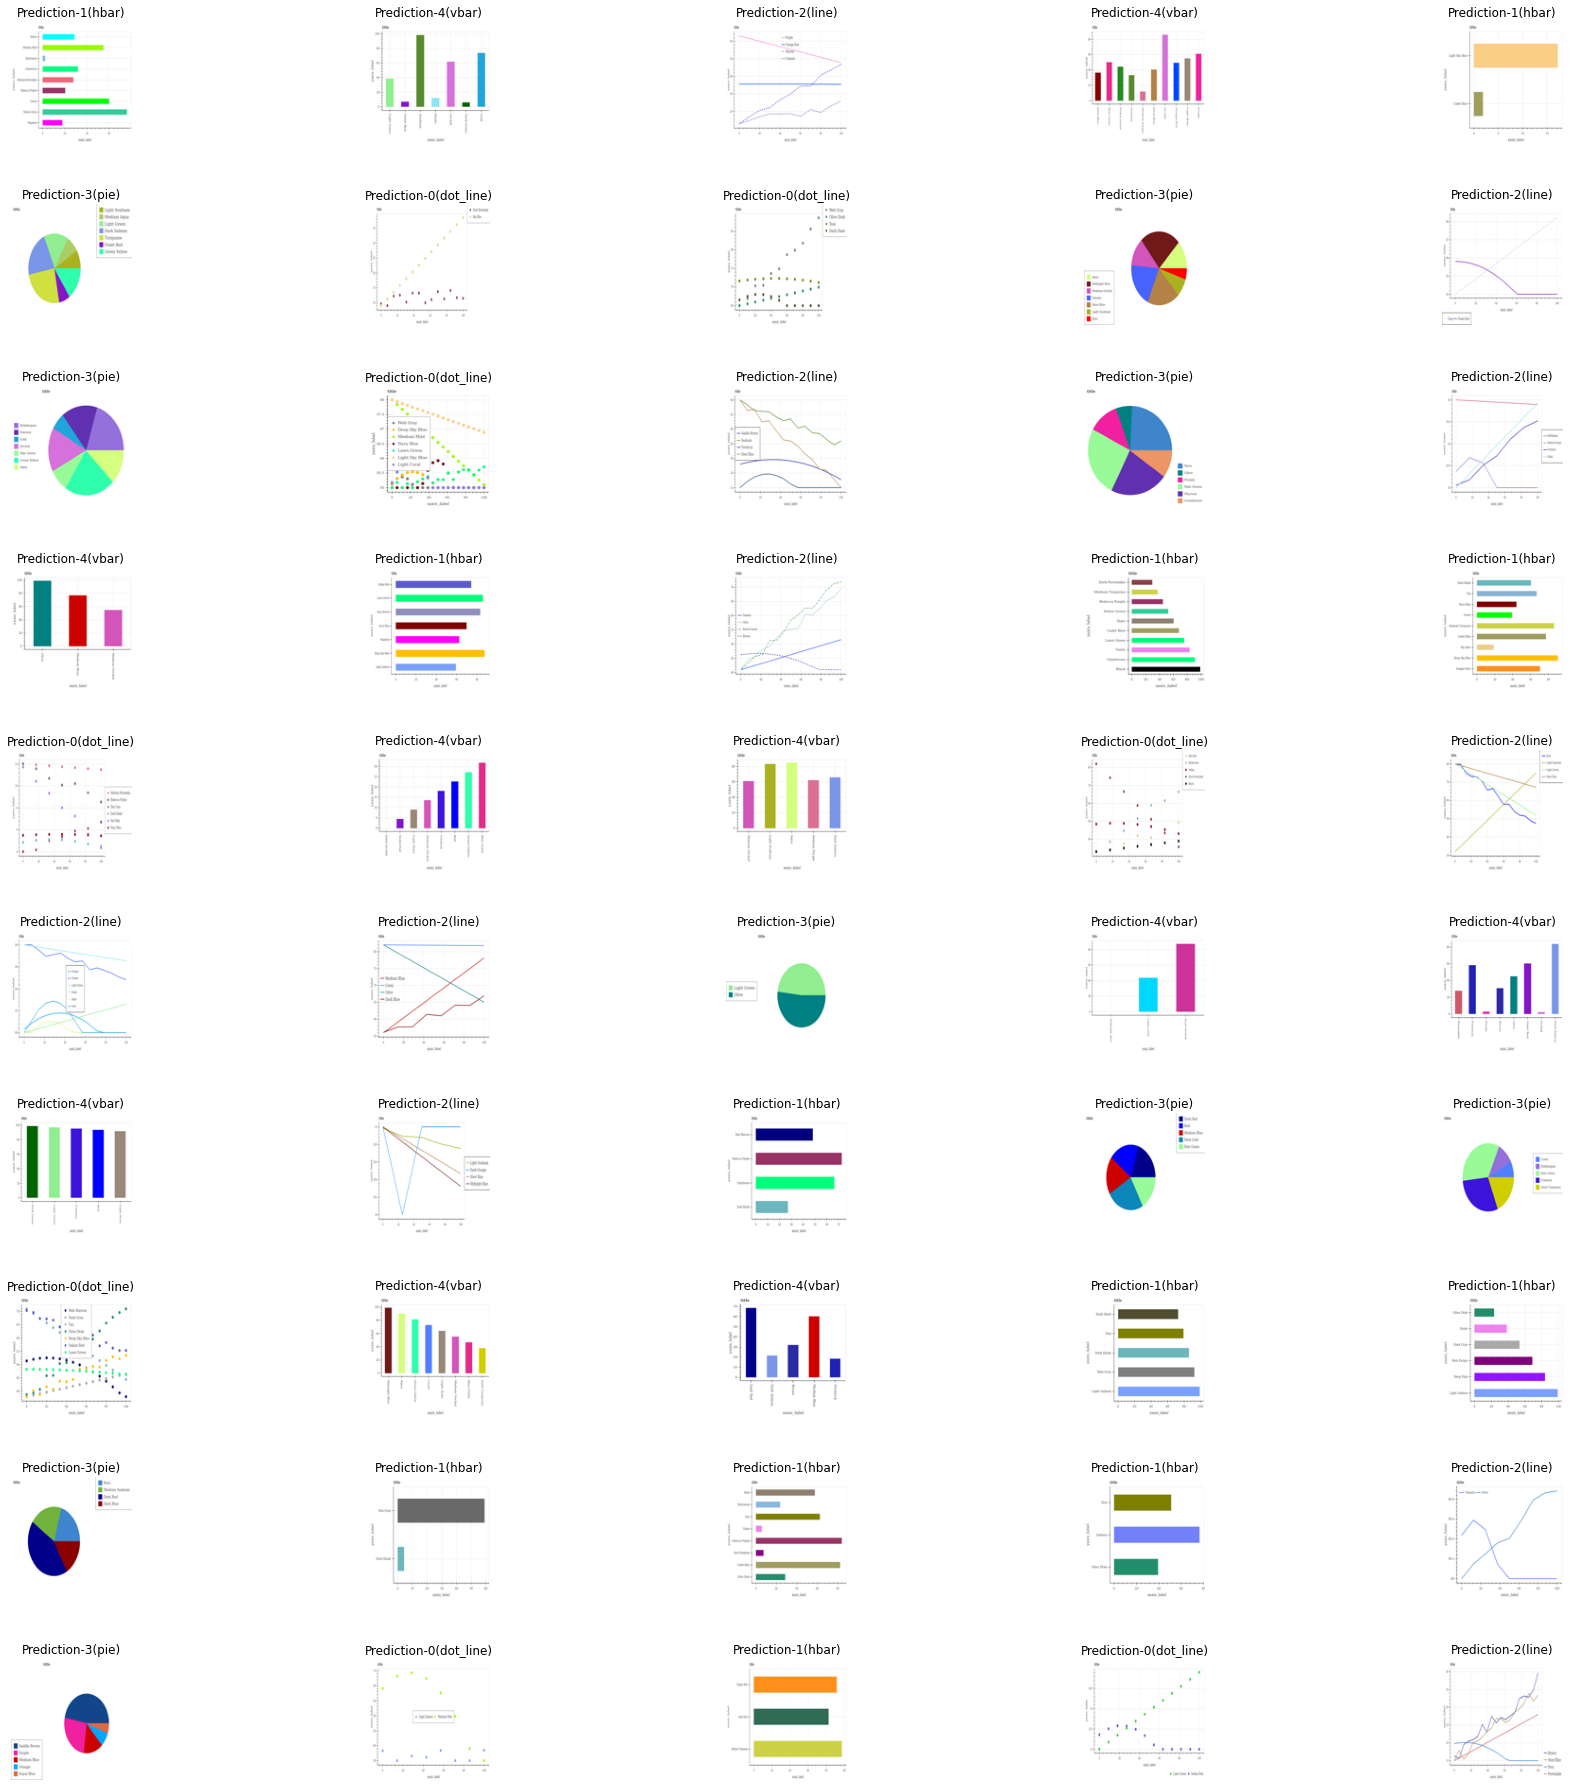

In [29]:
import numpy as np
prediction = model.predict(x_test)


fig, ax = plt.subplots(10, 5, figsize=(25,25))
fig.tight_layout(h_pad=4)
idx = 0
for i in range(0, 10):
    for j in range(0, 5):

        prediction_label = np.argmax(prediction[idx])
        ax[i][j].title.set_text('Prediction-{0}({1})'.format(prediction_label, Number(prediction_label).name))
        image = x_test[idx]
        ax[i][j].imshow(image)
        ax[i][j].axis("off")
        idx += 1 
plt.show()

Lets look the multiclass confusion matrix done on training data

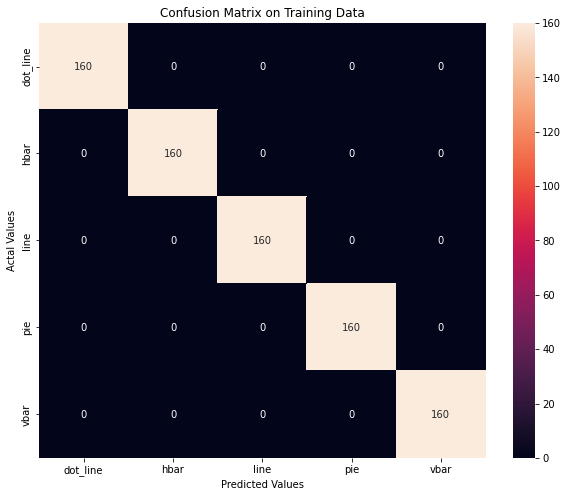

In [30]:
prediction = model.predict(x_train)
y_pred = [np.argmax(p) for p in prediction]

from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, y_train_enc)

cm_df = pd.DataFrame(cm,
                     index = ['dot_line','hbar','line', 'pie', 'vbar'], 
                     columns = ['dot_line','hbar','line', 'pie', 'vbar'])

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix on Training Data')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [26]:
test_loss, test_acc = model.evaluate(x_validation, y_validation_enc)
print('Accuracy:', test_acc)
print('Loss: ', test_loss)

7/7 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000
Accuracy: 1.0
Loss:  0.0


Also predictions on validation data

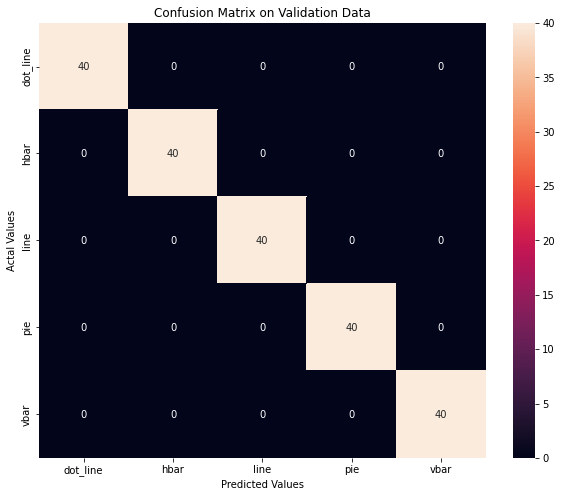

In [31]:
prediction = model.predict(x_validation)
y_pred = [np.argmax(p) for p in prediction]
cm = confusion_matrix(y_pred, y_validation_enc)

cm_df = pd.DataFrame(cm,
                     index = ['dot_line','hbar','line', 'pie', 'vbar'], 
                     columns = ['dot_line','hbar','line', 'pie', 'vbar'])

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix on Validation Data')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

**The pre-trained learnt the represent fast and was able to classify all the validation and training set** and from the predictions on test set, it looks the model is performing correctly.